# **Processamento Digital de Imagens - PDI**

# Dominio da frequencia

### Bibliotecas

In [1]:
import cv2
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

### Mascara de Filtros

In [2]:
# simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))

# creating a guassian filter
x = cv2.getGaussianKernel(5,10)
gaussian = x*x.T

# different edge detecting filters
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])
# sobel in x direction
sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

#### Organizando as mascaras

In [3]:
filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']

#### Criando espectro para plot das mascaras
o spectrum é usado apenas para a plotagem das imagens.

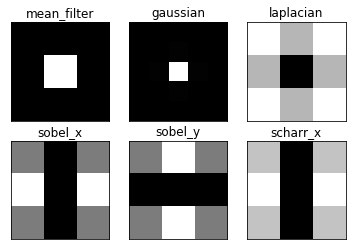

In [4]:
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])

plt.show()

# Aplicando filtros em frequencia

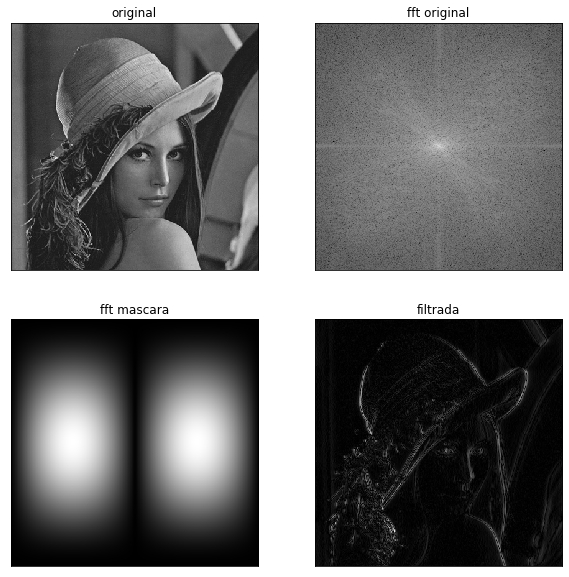

In [20]:
import sys
import numpy as np
from matplotlib import pyplot as plt

#lendo a imagem
img_1 = cv2.imread('lena.bmp',0)
img_1 = img_1[:-1,:-1]


import cv2
import numpy as np
# Recebe: -imagem em tons de cinza, -Filtro
# Retorno: -Vetor[-imagem original, -fft imagem original, -fft mascara, -imagem filtrada].
def frequency_filter(img,filter_):
    
    l_r = img.shape[0]
    c_r = img.shape[1]
    
    im = img.copy()
    
    if (l_r % 2) == 0:
        im = img[:-1,:]

    if (c_r % 2) == 0:
        im = img[:,:-1]

    l = im.shape[0]
    c = im.shape[1]

    #cv2.imshow('teste', im)
    #cv2.waitKey()


    #fft usando opencv e shift com numpy
    ##Com o metodo cv2.dft(...) o resultado e um array com dois canais, 
    ##sendo um array para o eixo real e outro para o imaginario
    ##A imagem precisa ser float
    img_fft = np.fft.fftshift((cv2.dft(np.float32(im),flags = cv2.DFT_COMPLEX_OUTPUT)))

    #mascaras no dominio do espaco (escolher uma)  
    if filter_ == 0:# Media
        mask = np.float32([[1, 1, 1],[1, 1, 1],[1, 1, 1]])*(1/9)
    elif filter_ == 1:# Gaussiano
        mask=np.float32([[0, 1, 0],[1,-4, 1],[0, 1, 0]])
    elif filter_ == 2:#sobelX
        mask = np.float32([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    else:#sobelY
        mask = np.float32([[1, 1, 1],[1, 1, 1],[1, 1, 1]])

    #mascara redimensionada (valores movidos para o centro)
    filter_mask = np.zeros((l,c))
    filter_mask[(l//2)-1:int(np.ceil(l/2))+1,(c//2)-1:int(np.ceil(c/2))+1] = mask
    
    #mascara no dominio da frequencia (fft e shift)
    fft_mask = np.fft.fftshift(cv2.dft(np.float32(filter_mask),flags = cv2.DFT_COMPLEX_OUTPUT))
    mask_abs = cv2.magnitude(fft_mask[:,:,0],fft_mask[:,:,1])

    #replica a magnitude da mascara para os dois canais
    fft_mask[:,:,0] = mask_abs
    fft_mask[:,:,1] = mask_abs

    #filtra no dominio da frequencia
    fft_filtered = cv2.multiply(img_fft,fft_mask)

    #inverte a FFT
    img_back = cv2.idft(np.fft.ifftshift(fft_filtered))
    #print(img_back[0,0,0])
    #cv2.imshow('teste0', img_back[:,:,0])
    #cv2.imshow('teste1', img_back[:,:,1])
    #cv2.waitKey()
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
    #print(img_back[0,0])
    #print(img_back.shape)
    img_back = cv2.normalize(img_back, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)
    

    #diferenca em relacao a imagem original
    #img_dif = cv2.normalize(img_back,  None, 0, 255, cv2.NORM_MINMAX)
    #img_dif = cv2.subtract(np.float32(im),img_dif)

    #image plot
    imagens = [im,
               np.log(cv2.magnitude(img_fft[:,:,0],img_fft[:,:,1])),
               mask_abs,
               img_back]         
    return imagens


#cv2.imshow('saida', cv2.cvtColor(freq(img_1)[3], cv2.COLOR_GRAY2BGR))
#cv2.waitKey(10000)

imagens = frequency_filter(img_1,2)


imgs = []
# Convertendo as imagens de saida para RGB.
for item in imagens:
    imgs.append((cv2.cvtColor(item, cv2.COLOR_GRAY2RGB)))

# Nomalizando os valores da imagem ques estavão em float para inteiro.    
for obj in range (len(imgs)):
    imgs[obj] = cv2.normalize(imgs[obj], None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)

# Plotando as imagens de saida.
titles = ['original','fft original','fft mascara','filtrada']
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(imgs[i],cmap = 'gray')
    plt.title(titles[i]), plt.xticks([]), plt.yticks([])

plt.show()